In [1]:
from typing import Any, Dict, Optional, Tuple, List, Iterator, Union
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from pytorch_lightning import LightningDataModule
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Sampler, SequentialSampler #random_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
from torch import Tensor
import sqlite3
import math
# from torch import default_generator, randperm
# from torch._utils import _accumulate
# from torch.utils.data.dataset import Subset
# from torch_geometric.data import Data
# from torch.utils.data import Sampler

/groups/icecube/moust/miniconda3/envs/icet2/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class BetaDistLoss(torch.nn.Module):
    def __init__(self):
        super(BetaDistLoss, self).__init__()

    def forward(self, inputs, target):
        # Discretize the targets into bins
        shrink = 0.000001  # To avoid NaNs
        target = target * (1 - 2 * shrink) + shrink / 2
        print(target)
        print(inputs[:, 0])
        print(inputs[:, 1])

        # Get alpha and beta parameters
        alpha = inputs[:, 0]+ torch.ones_like(inputs[:, 0])/100000
        beta = inputs[:, 1]+ torch.ones_like(inputs[:, 1])/100000

        # Create a Beta distribution with the predicted alpha and beta parameters
        beta_dist = torch.distributions.Beta(alpha, beta)

        # Calculate the log probability of the truth value
        log_prob = beta_dist.log_prob(target) #.squeeze(1)
        return -log_prob


In [2]:
csv_file = "/groups/icecube/petersen/GraphNetDatabaseRepository/Upgrade_Data/sqlite3/upgrade_pure_numu_selection_event_no.csv"
db_path = "/groups/icecube/petersen/GraphNetDatabaseRepository/Upgrade_Data/sqlite3/dev_step4_upgrade_028_with_noise_dynedge_pulsemap_v3_merger_aftercrash.db"


In [ ]:

def split_csv_based_on_db_rows(db_path, csv_path, int_list, table_name, output_path):
    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)

        # Read the CSV file into a pandas DataFrame, considering it doesn't have a header
    df = pd.read_csv(csv_path, ) #header=None

    # The column name of the DataFrame is 0, let's rename it to 'event_number' for clarity
    df.rename(columns={0: 'event_no'}, inplace=True)

    # Count the number of rows for each event_number in the SQLite table
    row_counts = df['event_no'].apply(lambda x: pd.read_sql_query(f"SELECT COUNT(*) FROM {table_name} WHERE event_no = {x}", conn).iloc[0,0])

    # Attach the row counts to the original DataFrame
    df['row_counts'] = row_counts

    # The input list of integers is assumed to be sorted, if not, sort it
    int_list.sort()

    # Create the ranges for splitting the CSV file
    ranges = [(0, int_list[0])] + [(int_list[i-1], int_list[i]) for i in range(1, len(int_list))] + [(int_list[-1], float('inf'))]

    # For each range, select the rows with 'row_counts' within that range and write to a new CSV file
    for i, (lower, upper) in enumerate(ranges):
        df_range = df[(df['row_counts'] >= lower) & (df['row_counts'] < upper)]
        df_range.drop(columns='row_counts').to_csv(f"{output_path}/output_{i+1}.csv", index=False)

    # Close the SQLite connection
    conn.close()

In [5]:
test_csv = "/groups/icecube/moust/storage/cached_event_no/upgrade_pure_numu_selection_event_no_test.csv"
train_csv = "/groups/icecube/moust/storage/cached_event_no/upgrade_pure_numu_selection_event_no_train.csv"
val_csv = "/groups/icecube/moust/storage/cached_event_no/upgrade_pure_numu_selection_event_no_val.csv"

In [8]:
df = pd.read_csv(val_csv)

In [6]:
csv_path = train_csv
conn = sqlite3.connect(db_path)

    # Read the CSV file into a pandas DataFrame, considering it doesn't have a header
df = pd.read_csv(csv_path, ) #header=None

# The column name of the DataFrame is 0, let's rename it to 'event_number' for clarity
df.rename(columns={0: 'event_no'}, inplace=True)

# Count the number of rows for each event_number in the SQLite table
row_counts = df['event_no'].apply(lambda x: pd.read_sql_query(
    f"SELECT COUNT(*) FROM SplitInIcePulses_dynedge_v2_Pulses WHERE event_no = {x}",
    conn).iloc[0,0]
    )

# Attach the row counts to the original DataFrame
df['row_counts'] = row_counts

<Axes: >

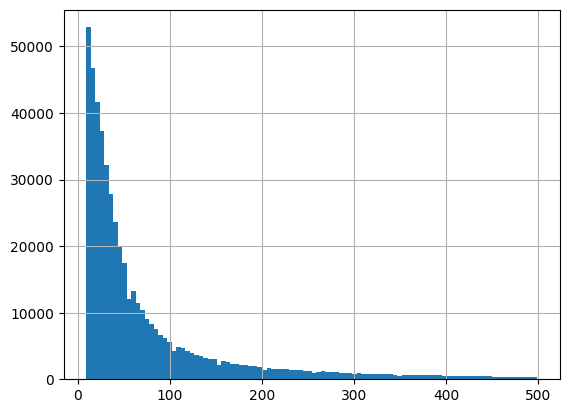

In [15]:
df.query("row_counts<500")['I '].hist(bins=100)

In [3]:


def fetch_data(database_path, condition, truth_cols=None, pulsemap_table='pulsemap', limit=None):
    # Ensure truth_cols is a list
    if truth_cols is not None and not isinstance(truth_cols, list):
        raise ValueError("truth_cols must be a list of column names")

    # Open connection to the SQLite database
    with sqlite3.connect(database_path) as conn:
        # Construct the SQL query
        query = "SELECT "

        # Add the columns from the truth table
        if truth_cols is not None:
            query += ", ".join(truth_cols) + ", "
        query += f"truth.event_no, COUNT({pulsemap_table}.event_no) as num_hits"

        # From the tables and condition
        query += f" FROM truth INNER JOIN {pulsemap_table} ON truth.event_no = {pulsemap_table}.event_no"
        query += f" WHERE {condition}"
        
        # Group by the event_no to get the count per event
        query += " GROUP BY truth.event_no"

        # If limit is specified, add it to the query
        if limit is not None:
            query += f" LIMIT {limit}"
        print(query)
        # Execute the SQL query and convert the result to a pandas dataframe
        df = pd.read_sql_query(query, conn)

    return df


In [4]:
# Example of usage:

condition = "interaction_type = 1 AND abs(pid) = 14"
pulsemap_table = 'SplitInIcePulses_dynedge_v2_Pulses'
truth_cols = ['position_x', 'position_y', 'position_z', "energy", "DeepCoreFilter_13", "zenith", "azimuth"]
df = fetch_data(db_path, condition, truth_cols,pulsemap_table=pulsemap_table)


SELECT position_x, position_y, position_z, energy, DeepCoreFilter_13, zenith, azimuth, truth.event_no, COUNT(SplitInIcePulses_dynedge_v2_Pulses.event_no) as num_hits FROM truth INNER JOIN SplitInIcePulses_dynedge_v2_Pulses ON truth.event_no = SplitInIcePulses_dynedge_v2_Pulses.event_no WHERE interaction_type = 1 AND abs(pid) = 14 GROUP BY truth.event_no


76.50100778883139 1 5487


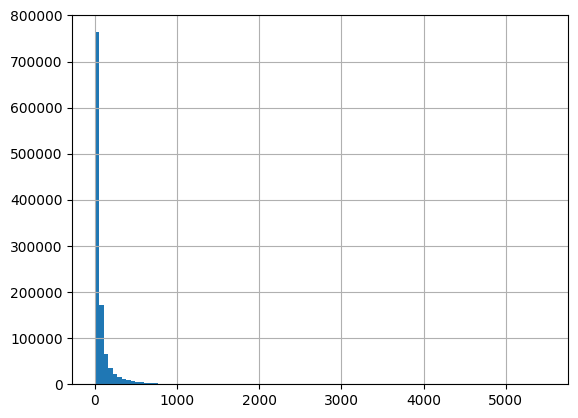

In [27]:
df["num_hits"].hist(bins=100)
print(df["num_hits"].mean(), df["num_hits"].min(), df["num_hits"].max())

In [38]:
df.query("DeepCoreFilter_13 ==0")["num_hits"].max()

2996

In [25]:
df

,position_x,position_y,position_z,energy,DeepCoreFilter_13,zenith,azimuth,event_no,num_hits
0,-140.530956,105.635303,-254.214612,171.855446,1.0,1.703052,1.216639,6,24
1,73.111683,119.668461,-409.190262,29.589351,1.0,2.604575,1.071225,20,35
2,100.812824,-82.082059,-287.492379,21.420834,0.0,2.332800,2.634142,28,37
3,-37.204169,-175.118857,-522.970785,136.834161,1.0,1.932008,3.019527,32,58
4,-73.225463,-61.796008,-406.121329,357.209465,1.0,1.331364,1.451155,46,61
...,...,...,...,...,...,...,...,...,...
1126223,178.586023,-25.486041,-139.512196,127.278664,0.0,1.078303,4.305911,7458089,12
1126224,97.910587,-161.750827,-449.376653,80.915397,1.0,2.169709,2.337068,7458096,40
1126225,89.659647,25.287358,-512.568564,19.127703,1.0,1.327295,1.969094,7458111,28
1126226,28.868065,34.967025,-138.205089,26.575545,1.0,0.930577,2.532479,7458127,20


<Axes: xlabel='num_hits', ylabel='Count'>

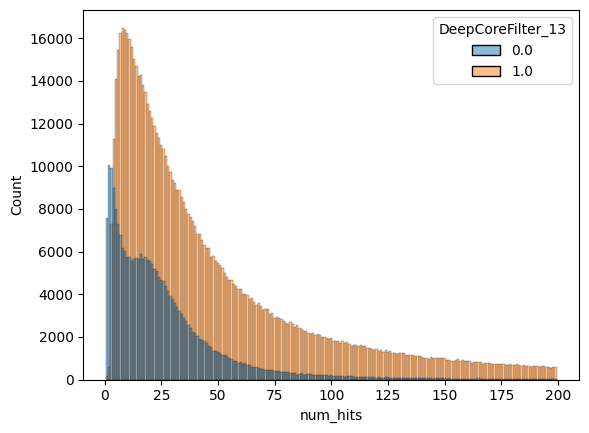

In [5]:
sns.histplot(data = df.query("num_hits < 200"),x="num_hits",hue="DeepCoreFilter_13", discrete=True)

<Axes: xlabel='energy', ylabel='Count'>

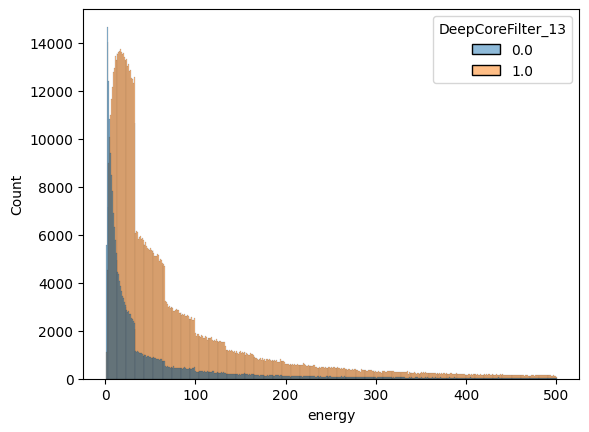

In [11]:
sns.histplot(data = df,x="energy",hue="DeepCoreFilter_13", discrete=True)

In [9]:
df["r"]= df["position_x"]**2 + df["position_y"]**2
df["r"] = df["r"].apply(np.sqrt)

<Axes: xlabel='r', ylabel='position_z'>

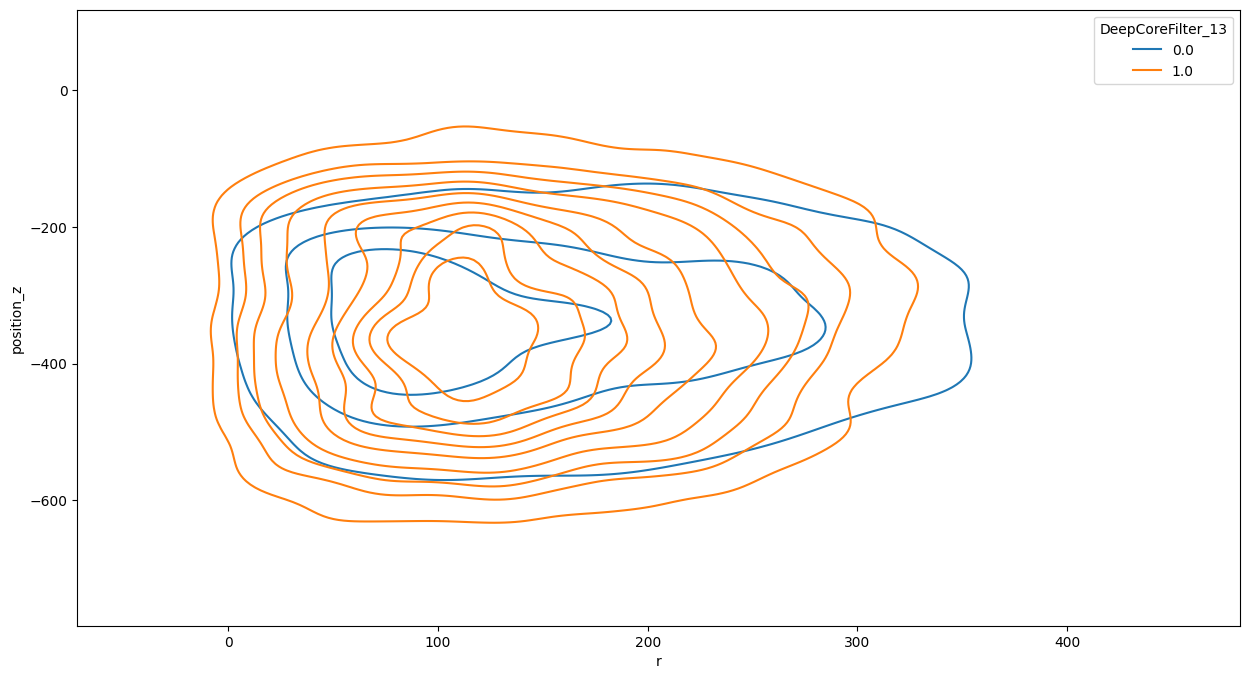

In [12]:
plt.figure(figsize=(15, 8))
sns.kdeplot(data= df[:10000], x= "r", y= "position_z", hue="DeepCoreFilter_13")

0.03243925741501721

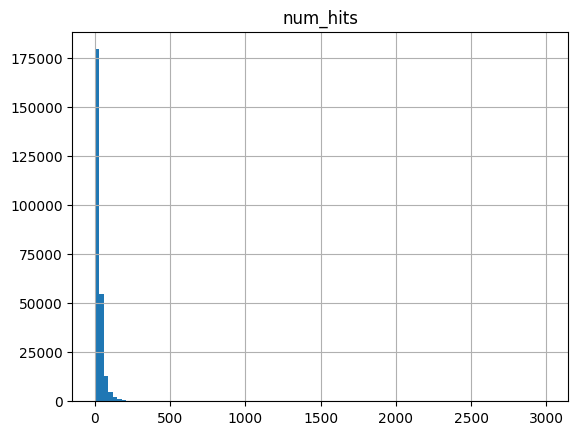

In [40]:
df.query("DeepCoreFilter_13 ==0").hist(bins=100, column="num_hits")
len(df.query("DeepCoreFilter_13 ==0 and num_hits < 5"))/len(df)

<Axes: >

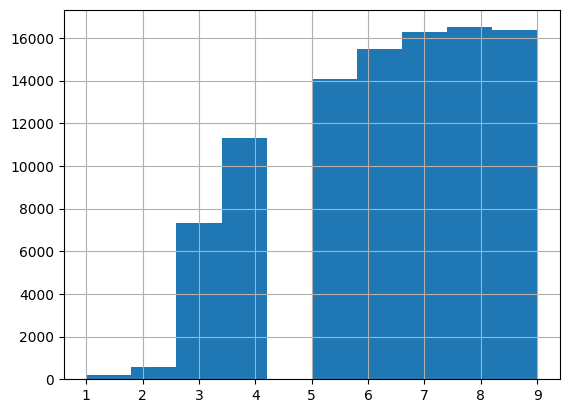

In [44]:
df.query("DeepCoreFilter_13 ==1 and num_hits < 10")["num_hits"].hist()

In [7]:
def count_events_in_intervals(df, boundaries, print_event_nos=False):
    # Add a lower and upper boundary
    boundaries = [0] + sorted(boundaries) + [float('inf')]

    # Iterate over each interval
    for i in range(len(boundaries) - 1):
        lower = boundaries[i]
        upper = boundaries[i + 1]

        # Filter the DataFrame for the current interval
        interval_df = df.query(f"{upper} > num_hits >= {lower}")

        # Print the number of events in the interval
        print(f"Number of event_no in interval [{lower}, {upper}): {len(interval_df)}")

        # If requested, print the event_no in the interval
        if print_event_nos:
            print(f"num_hits in interval [{lower}, {upper}): {sorted(interval_df['num_hits'].unique())}")

boundaries = [3, 5, 8, 10, 12,14,16,18, 20, 23,26, 30, 35, 40, 45, 50, 60, 70, 80, 100, 150, 200, 250, 300, 400, 500, 600, 800, 1200 ]
count_events_in_intervals(df, boundaries, print_event_nos=False)


Number of event_no in interval [0, 3): 18371
Number of event_no in interval [3, 5): 37531
Number of event_no in interval [5, 8): 67906
Number of event_no in interval [8, 10): 45082
Number of event_no in interval [10, 12): 43671
Number of event_no in interval [12, 14): 41874
Number of event_no in interval [14, 16): 40284
Number of event_no in interval [16, 18): 39568
Number of event_no in interval [18, 20): 37717
Number of event_no in interval [20, 23): 52914
Number of event_no in interval [23, 26): 48504
Number of event_no in interval [26, 30): 58138
Number of event_no in interval [30, 35): 62031
Number of event_no in interval [35, 40): 51977
Number of event_no in interval [40, 45): 43484
Number of event_no in interval [45, 50): 36959
Number of event_no in interval [50, 60): 58701
Number of event_no in interval [60, 70): 44494
Number of event_no in interval [70, 80): 34616
Number of event_no in interval [80, 100): 50609
Number of event_no in interval [100, 150): 72776
Number of event_n

In [49]:
import os
from sklearn.model_selection import train_test_split

def save_splits(df, boundaries, directory, suffix, test_size=0.2, random_state=42):
    # Add a lower and upper boundary
    boundaries = [float('-inf')] + sorted(boundaries) + [float('inf')]

    # Create the directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    # Iterate over each interval
    for i in range(len(boundaries) - 1):
        lower = boundaries[i]
        upper = boundaries[i + 1]

        # Filter the DataFrame for the current interval
        interval_df = df.query(f"{upper} > num_hits >= {lower}")
        event_nos = interval_df['event_no']
        
        # Split the event_no into training, testing, and validation sets
        train_event_nos, test_event_nos = train_test_split(event_nos, test_size=test_size, random_state=random_state)
        train_event_nos, val_event_nos = train_test_split(train_event_nos, test_size=test_size, random_state=random_state)

        # Define the file name
        base_filename = f"interval_{lower}_{upper}_events_{len(event_nos)}_{suffix}"

        # Save each set to a separate CSV file
        train_event_nos.to_csv(os.path.join(directory, f"{base_filename}_train.csv"), index=False)
        test_event_nos.to_csv(os.path.join(directory, f"{base_filename}_test.csv"), index=False)
        val_event_nos.to_csv(os.path.join(directory, f"{base_filename}_val.csv"), index=False)


In [50]:
from sklearn.model_selection import train_test_split

def save_splits(df, boundaries, directory, suffix, test_val_size=0.2, random_state=42):
    # Add a lower and upper boundary
    boundaries = [float('-inf')] + sorted(boundaries) + [float('inf')]

    # Create the directory if it doesn't exist
    os.makedirs(directory, exist_ok=True)

    # Iterate over each interval
    for i in range(len(boundaries) - 1):
        lower = boundaries[i]
        upper = boundaries[i + 1]

        # Filter the DataFrame for the current interval
        interval_df = df.query(f"{upper} > num_hits >= {lower}")
        event_nos = interval_df['event_no']
        
        # Split the event_no into training+validation and test sets
        train_val_event_nos, test_event_nos = train_test_split(event_nos, test_size=test_val_size, random_state=random_state)
        # Further split the training+validation set into training and validation sets
        train_event_nos, val_event_nos = train_test_split(train_val_event_nos, test_size=test_val_size/(1-test_val_size), random_state=random_state)

        # Define the file name
        base_filename = f"interval_{lower}_{upper}_events_{len(event_nos)}_{suffix}"

        # Save each set to a separate CSV file
        train_event_nos.to_csv(os.path.join(directory, f"{base_filename}_train.csv"), index=False)
        test_event_nos.to_csv(os.path.join(directory, f"{base_filename}_test.csv"), index=False)
        val_event_nos.to_csv(os.path.join(directory, f"{base_filename}_val.csv"), index=False)


In [16]:
chunk_csv_train = [
    "/groups/icecube/moust/storage/chunked_event_no/interval_5_8_events_67906_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_8_10_events_45082_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_10_12_events_43671_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_12_14_events_41874_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_14_16_events_40284_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_16_18_events_39568_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_18_20_events_37717_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_20_23_events_52914_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_23_26_events_48504_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_26_30_events_58138_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_30_35_events_62031_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_35_40_events_51977_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_40_45_events_43484_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_45_50_events_36959_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_50_60_events_58701_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_60_70_events_44494_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_70_80_events_34616_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_80_100_events_50609_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_100_150_events_72776_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_150_200_events_38790_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_200_250_events_24514_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_250_300_events_16919_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv",
]
chunk_csv_test = [
    "/groups/icecube/moust/storage/chunked_event_no/interval_5_8_events_67906_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_8_10_events_45082_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_10_12_events_43671_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_12_14_events_41874_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_14_16_events_40284_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_16_18_events_39568_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_18_20_events_37717_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_20_23_events_52914_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_23_26_events_48504_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_26_30_events_58138_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_30_35_events_62031_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_35_40_events_51977_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_40_45_events_43484_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_45_50_events_36959_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_50_60_events_58701_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_60_70_events_44494_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_70_80_events_34616_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_80_100_events_50609_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_100_150_events_72776_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_150_200_events_38790_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_200_250_events_24514_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_250_300_events_16919_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_test.csv",
]
chunk_csv_val = [
    "/groups/icecube/moust/storage/chunked_event_no/interval_5_8_events_67906_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_8_10_events_45082_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_10_12_events_43671_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_12_14_events_41874_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_14_16_events_40284_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_16_18_events_39568_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_18_20_events_37717_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_20_23_events_52914_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_23_26_events_48504_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_26_30_events_58138_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_30_35_events_62031_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_35_40_events_51977_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_40_45_events_43484_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_45_50_events_36959_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_50_60_events_58701_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_60_70_events_44494_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_70_80_events_34616_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_80_100_events_50609_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_100_150_events_72776_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_150_200_events_38790_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_200_250_events_24514_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
    "/groups/icecube/moust/storage/chunked_event_no/interval_250_300_events_16919_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv",
]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_val = pd.DataFrame()

for csv in chunk_csv_train:
    df = pd.read_csv(csv)
    df_train = pd.concat([df_train, df])
for csv in chunk_csv_test:
    df = pd.read_csv(csv)
    df_test = pd.concat([df_test, df])
for csv in chunk_csv_val:
    df = pd.read_csv(csv)
    df_val = pd.concat([df_val, df])


In [12]:
df_val_test = pd.read_csv("/groups/icecube/moust/storage/chunked_event_no/interval_5_8_events_67906_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_val.csv")

In [18]:
df_train.sort_values(by=['event_no'], inplace=True)
df_train.to_csv("/groups/icecube/moust/work/nmo_analysis/reco/training/selections/tranformer_comparison_train.csv", index=False)
df_test.sort_values(by=['event_no'], inplace=True)
df_test.to_csv("/groups/icecube/moust/work/nmo_analysis/reco/training/selections/tranformer_comparison_test.csv", index=False)
df_val.sort_values(by=['event_no'], inplace=True)
df_val.to_csv("/groups/icecube/moust/work/nmo_analysis/reco/training/selections/tranformer_comparison_val.csv", index=False)

In [51]:
directory = '/groups/icecube/moust/storage/chunked_event_no/'
suffix = 'SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter'
save_splits(df, boundaries, directory, suffix)

In [54]:
import glob
import os

def print_csv_files(directory, prefix):
    # Get all CSV files in the directory that match the prefix
    csv_files = glob.glob(os.path.join(directory, f"*_{prefix}.csv"))

    # Create a custom sorting key based on the interval boundaries
    def sorting_key(filename):
        # Extract the interval information
        base_name = os.path.basename(filename)
        interval_info = base_name.split('_')[1:3]
        lower, upper = map(float, interval_info)
        return lower, upper

    # Sort the file names based on the interval info
    csv_files.sort(key=sorting_key)

    # Print the file names
    for file in csv_files:
        print(f"- {os.path.basename(file)}")

# Use the function
print("Training files:")
print_csv_files(directory, 'train')
print("\nTesting files:")
print_csv_files(directory, 'test')
print("\nValidation files:")
print_csv_files(directory, 'val')


Training files:
- interval_-inf_3_events_18371_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_3_5_events_37531_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_5_8_events_67906_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_8_10_events_45082_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_10_12_events_43671_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_12_14_events_41874_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_14_16_events_40284_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_16_18_events_39568_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_18_20_events_37717_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_20_23_events_52914_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.csv
- interval_23_26_events_48504_SplitInIcePulses_dynedge_v2_Pulses_DeepCoreFilter_train.cs

In [39]:
print(len(df.query("row_counts<11")))
print(df.query("row_counts<11")["row_counts"].unique())
print(len(df.query("13>row_counts>=11")))
print(df.query("13>row_counts>=11")["row_counts"].unique())
print(len(df.query("15>row_counts>=13")))
print(df.query("15>row_counts>=13")["row_counts"].unique())
print(len(df.query("17>row_counts>=15")))
print(df.query("17>row_counts>=15")["row_counts"].unique())
print(len(df.query("19>row_counts>=17")))
print(df.query("19>row_counts>=17")["row_counts"].unique())
print(len(df.query("21>row_counts>=19")))
print(df.query("21>row_counts>=19")["row_counts"].unique())
print(len(df.query("24>row_counts>=21")))
print(df.query("24>row_counts>=21")["row_counts"].unique())
print(len(df.query("27>row_counts>=24")))
print(df.query("27>row_counts>=24")["row_counts"].unique())
print(len(df.query("30>row_counts>=27")))
print(df.query("30>row_counts>=27")["row_counts"].unique())
print(len(df.query("33>row_counts>=30")))
print(df.query("33>row_counts>=30")["row_counts"].unique())
print(len(df.query("33>row_counts>=33")))
print(df.query("33>row_counts>=33")["row_counts"].unique())


21862
[ 9 10]
21078
[12 11]
19636
[13 14]
18970
[15 16]
18109
[17 18]
17274
[20 19]
24458
[22 21 23]
22912
[24 25 26]
21116
[29 27 28]
19373
[32 30 31]


In [61]:
np_array = np.array([])
np.append(np_array,np.array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

In [11]:
# split_csv_based_on_db_rows(
#     db_path,
#     train_csv, 
#     [5,10,20,40,100,200], 
#     "SplitInIcePulses_dynedge_v2_Pulses", 
#     "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/train")
# split_csv_based_on_db_rows(
#     db_path,
#     test_csv, 
#     [5,10,20,40,100,200], 
#     "SplitInIcePulses_dynedge_v2_Pulses", 
#     "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/test")
split_csv_based_on_db_rows(
    db_path,
    val_csv, 
    [5,10,20,40,100,200], 
    "SplitInIcePulses_dynedge_v2_Pulses", 
    "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/val")

In [9]:
df = pd.read_csv(csv_file,)
df.head()

,6
0,20
1,28
2,32
3,46
4,54


In [14]:
split_csv_based_on_db_rows(db_path, csv_file, [20,100], "SplitInIcePulses_dynedge_v2_Pulses", "/groups/icecube/petersen/GraphNetDatabaseRepository/Upgrade_Data/sqlite3/upgrade_pure_numu_selection_event_no_split")

In [5]:
import os
import sqlite3
import numpy as np
import pandas as pd
from scipy.stats import expon

# Function to generate exponential distribution
def generate_exponential_distribution(n, scale=50, size=1):
    return expon.rvs(scale=scale, size=size)

# Create a SQLite database in a file
db_filename = "events.db"
conn = sqlite3.connect(db_filename)
c = conn.cursor()

# # Create tables
# c.execute("CREATE TABLE truth (event_no INTEGER PRIMARY KEY, energy REAL, inelasticity REAL)")
# c.execute("CREATE TABLE pulsemap (event_no INTEGER, dom_x REAL, dom_y REAL, dom_z REAL, time REAL, charge REAL)")

# # Populate tables
# np.random.seed(0)
# num_events = 10000

# # Generate event numbers
# event_nos = np.arange(num_events)

# # Generate energies and inelasticities
# energies = np.random.uniform(size=num_events)
# inelasticities = np.random.uniform(size=num_events)

# # Populate truth table
# for event_no, energy, inelasticity in zip(event_nos, energies, inelasticities):
#     # Convert numpy int64 to native int
#     event_no = int(event_no)
#     c.execute("INSERT INTO truth VALUES (?, ?, ?)", (event_no, energy, inelasticity))

# # Generate pulsemap data
# for event_no in event_nos:
#     num_rows = int(generate_exponential_distribution(n=1, scale=30, size=1))
#     for _ in range(num_rows):
#         dom_x, dom_y, dom_z, time, charge = np.random.uniform(size=5)
#         # Convert numpy int64 to native int
#         event_no = int(event_no)
#         c.execute("INSERT INTO pulsemap VALUES (?, ?, ?, ?, ?, ?)", (event_no, dom_x, dom_y, dom_z, time, charge))

# # Commit changes
# conn.commit()

# Create histogram of the number of hits in the events
c.execute("SELECT event_no, COUNT(*) FROM pulsemap GROUP BY event_no")
data = c.fetchall()
event_nos, counts = zip(*data)

# Divide event_no's into four groups based on the number of rows with the same event_no
counts = np.array(counts)
event_nos = np.array(event_nos)
indices = counts.argsort()
sorted_event_nos = event_nos[indices]
group1, group2, group3, group4 = np.array_split(sorted_event_nos, 4)

# Write event_no's for each group to a separate CSV file
# os.makedirs("/mnt/data/event_groups", exist_ok=True)
np.savetxt("/mnt/data/event_groups/group1.csv", group1, delimiter=",", fmt="%d")
np.savetxt("/mnt/data/event_groups/group2.csv", group2, delimiter=",", fmt="%d")
np.savetxt("/mnt/data/event_groups/group3.csv", group3, delimiter=",", fmt="%d")
np.savetxt("/mnt/data/event_groups/group4.csv", group4, delimiter=",", fmt="%d")

db_filename, "/mnt/data/event_groups/group1.csv", "/mnt/data/event_groups/group2.csv", "/mnt/data/event_groups/group3.csv", "/mnt/data/event_groups/group4.csv"


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/event_groups/group1.csv'

In [21]:
csv_file = "/groups/icecube/petersen/GraphNetDatabaseRepository/Upgrade_Data/sqlite3/upgrade_pure_numu_selection_event_no.csv"
db_path = "/groups/icecube/petersen/GraphNetDatabaseRepository/Upgrade_Data/sqlite3/dev_step4_upgrade_028_with_noise_dynedge_pulsemap_v3_merger_aftercrash.db"
df = pd.read_csv(csv_file)
print(len(df))
csv_filenames = [
    "/groups/icecube/moust/storage/cached_event_no/output_1.csv",
    "/groups/icecube/moust/storage/cached_event_no/output_2.csv", 
    "/groups/icecube/moust/storage/cached_event_no/output_3.csv"
    ]
event_numbers = []
for csv_filename in csv_filenames:
    df = pd.read_csv(csv_filename)
    event_numbers.extend(df['event_no'].tolist())
len(event_numbers)

1098831


1098832

In [4]:
conn = sqlite3.connect(db_path)
c = conn.cursor()
c.execute("SELECT event_no, COUNT(*) FROM SplitInIcePulses_dynedge_v2_Pulses GROUP BY event_no")
data = c.fetchall()

In [11]:
query_all ="SELECT * FROM truth"
with sqlite3.connect(db_path) as conn:
    db_tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type = 'table'", conn)
    print('Tables within the SQL database is:')
    print(db_tables)
    print()
    mini_db = {name:  pd.read_sql_query(f"SELECT * FROM {name} LIMIT 3000", conn) for name in db_tables.name}

Tables within the SQL database is:
                                       name
0                                     truth
1                         pisa_dependencies
2                          SplitInIcePulses
3               SplitInIcePulses_TruthFlags
4                   SplitIceCubePulsesTWSRT
5        SplitIceCubePulsesTWSRT_TruthFlags
6         SplitInIcePulses_GraphSage_Pulses
7    SplitInIcePulses_GraphSage_Predictions
8   SplitInIcePulses_dynedge_v2_Predictions
9        SplitInIcePulses_dynedge_v2_Pulses
10    no_upgrade_strings_dynedge_v2_cleaned



In [3]:
class ChunkDataset(Dataset):
    def __init__(self, db_filename, csv_filenames):
        # self.conn = sqlite3.connect(db_filename)
        # self.c = self.conn.cursor()
        # self.c.execute("SELECT event_no FROM truth")
        # self.event_nos = [row[0] for row in self.c.fetchall()]
        self.conn = sqlite3.connect(db_filename)
        self.c = self.conn.cursor()
        self.event_nos = []
        for csv_filename in csv_filenames:
            df = pd.read_csv(csv_filename)
            self.event_nos.extend(df['event_no'].tolist())

    def __len__(self):
        return len(self.event_nos)

    def __getitem__(self, idx):
        event_no = self.event_nos[idx]
        self.c.execute("SELECT energy FROM truth WHERE event_no = ?", (event_no,))
        energy = self.c.fetchone()[0]
        self.c.execute("SELECT dom_x, dom_y, dom_z, dom_time, charge FROM SplitInIcePulses_dynedge_v2_Pulses WHERE event_no = ?", (event_no,))
        pulsemap_data = self.c.fetchall()
        return torch.tensor(energy, dtype=torch.float32), torch.tensor(pulsemap_data, dtype=torch.float32)
    
class ChunkSampler(Sampler):
    def __init__(self, csv_filenames, batch_sizes):
        self.event_nos = []
        for csv_filename, batch_size in zip(csv_filenames, batch_sizes):
            # event_nos = np.loadtxt(csv_filename, delimiter=",", dtype=int).tolist()
            event_nos = pd.read_csv(csv_filename)['event_no'].tolist()
            self.event_nos.extend([event_nos[i:i + batch_size] for i in range(0, len(event_nos), batch_size)])

    def __iter__(self):
        return iter(self.event_nos)

    def __len__(self):
        return len(self.event_nos)
    
def collate_fn(data):
    # Split the data into energies and pulsemap data
    energies, pulsemap_data = zip(*data)
    
    # Pad the pulsemap data
    pulsemap_data = pad_sequence(pulsemap_data, batch_first=True)
    
    return torch.stack(energies), pulsemap_data

csv_filenames = [
    "/groups/icecube/moust/storage/cached_event_no/output_1.csv",
    "/groups/icecube/moust/storage/cached_event_no/output_2.csv", 
    "/groups/icecube/moust/storage/cached_event_no/output_3.csv"
    ]

# csv_file = "/groups/icecube/petersen/GraphNetDatabaseRepository/Upgrade_Data/sqlite3/upgrade_pure_numu_selection_event_no.csv"
db_path = "/groups/icecube/petersen/GraphNetDatabaseRepository/Upgrade_Data/sqlite3/dev_step4_upgrade_028_with_noise_dynedge_pulsemap_v3_merger_aftercrash.db"

# Test the EventDataset
dataset = ChunkDataset(db_path, csv_filenames ) #db_filename
batch_sizes = [100, 50, 10]  # Adjust these batch sizes according to your machine's memory limits
sampler = ChunkSampler(csv_filenames, batch_sizes)
dataloader = DataLoader(dataset, batch_sampler=sampler, collate_fn=collate_fn, num_workers=4)

print(dataset[0])  # Print the first sample from the dataset
print(len(dataset))  # Print the total number of samples in the dataset

(tensor(24.1367), tensor([[ 1.9434e+02, -3.0920e+01, -2.1078e+02,  1.1114e+04,  1.1386e+00],
        [ 9.0490e+01,  8.2350e+01, -1.6214e+02,  1.0005e+04,  4.8686e-01],
        [ 9.0490e+01,  8.2350e+01, -1.9619e+02,  9.8812e+03,  3.0716e-01],
        [ 9.0490e+01,  8.2350e+01, -2.1321e+02,  1.0058e+04,  8.5537e-01],
        [ 9.0490e+01,  8.2350e+01, -2.3023e+02,  9.9392e+03,  1.3410e+00],
        [ 9.0490e+01,  8.2350e+01, -2.3023e+02,  9.9442e+03,  1.1514e+00],
        [ 9.0490e+01,  8.2350e+01, -2.3023e+02,  9.9967e+03,  2.4345e-01],
        [ 9.0490e+01,  8.2350e+01, -2.4725e+02,  9.9892e+03,  8.4372e-01],
        [ 1.3203e+02,  2.0298e+02, -1.7809e+02,  1.0410e+04,  5.9601e-01],
        [ 4.1600e+01,  3.5490e+01, -2.4901e+02,  1.0430e+04,  4.9121e-01],
        [ 1.0694e+02,  2.7090e+01, -1.8880e+02,  1.0353e+04,  7.8922e-01],
        [ 1.1319e+02, -6.0470e+01, -3.7837e+02,  1.1606e+04,  6.4532e-01],
        [ 2.6957e+01, -3.1191e+01, -3.1668e+02,  1.0851e+04,  1.0357e+00]]))
10988

In [17]:
event_numbers = []
for csv_filename in csv_filenames:
    df = pd.read_csv(csv_filename)
    event_numbers.extend(df['event_no'].tolist())

In [24]:


class EventSampler(Sampler):
    def __init__(self, csv_filenames, batch_sizes):
        self.event_nos = []
        for csv_filename, batch_size in zip(csv_filenames, batch_sizes):
            # event_nos = np.loadtxt(csv_filename, delimiter=",", dtype=int).tolist()
            event_nos = pd.read_csv(csv_filename)['event_no'].tolist()
            self.event_nos.extend([event_nos[i:i + batch_size] for i in range(0, len(event_nos), batch_size)])

    def __iter__(self):
        return iter(self.event_nos)

    def __len__(self):
        return len(self.event_nos)
    
def collate_fn(data):
    # Split the data into energies and pulsemap data
    energies, pulsemap_data = zip(*data)
    
    # Pad the pulsemap data
    pulsemap_data = pad_sequence(pulsemap_data, batch_first=True)
    
    return torch.stack(energies), pulsemap_data

csv_filenames = [
    "/groups/icecube/moust/storage/cached_event_no/output_1.csv",
    "/groups/icecube/moust/storage/cached_event_no/output_2.csv", 
    "/groups/icecube/moust/storage/cached_event_no/output_3.csv"
    ]

batch_sizes = [100, 50, 10]  # Adjust these batch sizes according to your machine's memory limits
sampler = EventSampler(csv_filenames, batch_sizes)
print(len(sampler))  # Print the total number of batches in the sampler
# print(sampler[0])  # Print the first batch from the sampler


37930


TypeError: 'EventSampler' object is not subscriptable

In [25]:
def collate_fn(data):
    # Split the data into energies and pulsemap data
    energies, pulsemap_data = zip(*data)
    
    # Pad the pulsemap data
    pulsemap_data = pad_sequence(pulsemap_data, batch_first=True)
    
    return torch.stack(energies), pulsemap_data

# Test the collate function with the first two samples from the dataset
collate_fn([dataset[0], dataset[1]])

(tensor([24.1367, 18.3989]),
 tensor([[[ 1.9434e+02, -3.0920e+01, -2.1078e+02,  1.1114e+04,  1.1386e+00],
          [ 9.0490e+01,  8.2350e+01, -1.6214e+02,  1.0005e+04,  4.8686e-01],
          [ 9.0490e+01,  8.2350e+01, -1.9619e+02,  9.8812e+03,  3.0716e-01],
          [ 9.0490e+01,  8.2350e+01, -2.1321e+02,  1.0058e+04,  8.5537e-01],
          [ 9.0490e+01,  8.2350e+01, -2.3023e+02,  9.9392e+03,  1.3410e+00],
          [ 9.0490e+01,  8.2350e+01, -2.3023e+02,  9.9442e+03,  1.1514e+00],
          [ 9.0490e+01,  8.2350e+01, -2.3023e+02,  9.9967e+03,  2.4345e-01],
          [ 9.0490e+01,  8.2350e+01, -2.4725e+02,  9.9892e+03,  8.4372e-01],
          [ 1.3203e+02,  2.0298e+02, -1.7809e+02,  1.0410e+04,  5.9601e-01],
          [ 4.1600e+01,  3.5490e+01, -2.4901e+02,  1.0430e+04,  4.9121e-01],
          [ 1.0694e+02,  2.7090e+01, -1.8880e+02,  1.0353e+04,  7.8922e-01],
          [ 1.1319e+02, -6.0470e+01, -3.7837e+02,  1.1606e+04,  6.4532e-01],
          [ 2.6957e+01, -3.1191e+01, -3.1668e+0

In [26]:
batch_sizes = [100, 50, 10]  # Adjust these batch sizes according to your machine's memory limits
sampler = EventSampler(csv_filenames, batch_sizes)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_sampler=sampler, collate_fn=collate_fn, num_workers=4)


In [32]:
for energies, pulsemap_data in dataloader:
    print(energies.shape)
    print(pulsemap_data.shape)
    break


torch.Size([100])
torch.Size([100, 19, 5])


In [21]:
class ChunkDataset(Dataset):
    """
    PyTorch dataset for loading chunked data from an SQLite database.
    This dataset retrieves pulsemap and truth data for each event from the database.

    Args:
        db_filename (str): Filename of the SQLite database.
        csv_filenames (list of str): List of CSV filenames containing event numbers.
        pulsemap_table (str): Name of the table containing pulsemap data.
        truth_table (str): Name of the table containing truth data.
        truth_variable (str): Name of the variable to query from the truth table.
        feature_variables (list of str): List of variable names to query from the pulsemap table.
    """

    def __init__(
        self,
        db_path: str,
        csv_filenames: List[str],
        pulsemap_table: str,
        truth_table: str,
        truth_variable: str,
        feature_variables: List[str]
    ) -> None:
        self.conn = sqlite3.connect(db_path)  # Connect to the SQLite database
        self.c = self.conn.cursor()
        self.event_nos = []
        for csv_filename in csv_filenames:
            df = pd.read_csv(csv_filename)
            self.event_nos.extend(df['event_no'].tolist())  # Collect event numbers from CSV files
        self.pulsemap_table = pulsemap_table  # Name of the table containing pulsemap data
        self.truth_table = truth_table  # Name of the table containing truth data
        self.truth_variable = truth_variable  # Name of the variable to query from the truth table
        self.feature_variables = feature_variables  # List of variable names to query from the pulsemap table

    def __len__(self) -> int:
        return len(self.event_nos)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        event_no = self.event_nos[idx]
        # Query the truth variable for the given event number
        self.c.execute(f"SELECT {self.truth_variable} FROM {self.truth_table} WHERE event_no = ?", (event_no,))
        truth_value = self.c.fetchone()[0]
        feature_query = ', '.join(self.feature_variables)
        # Query the feature variables from the pulsemap table for the given event number
        self.c.execute(f"SELECT {feature_query} FROM {self.pulsemap_table} WHERE event_no = ?", (event_no,))
        pulsemap_data = self.c.fetchall()
        return torch.tensor(truth_value, dtype=torch.float32), torch.tensor(pulsemap_data, dtype=torch.float32)
    
    def close_connection(self) -> None:
        self.conn.close()


class ChunkSampler(Sampler):
    """
    PyTorch sampler for creating chunks from event numbers.

    Args:
        csv_filenames (List[str]): List of CSV filenames containing event numbers.
        batch_sizes (List[int]): List of batch sizes for each CSV file.
    """

    def __init__(self, csv_filenames: List[str], batch_sizes: List[int]) -> None:
        self.event_nos = []
        for csv_filename, batch_size in zip(csv_filenames, batch_sizes):
            event_nos = pd.read_csv(csv_filename)['event_no'].tolist()
            self.event_nos.extend([event_nos[i:i + batch_size] for i in range(0, len(event_nos), batch_size)])

    def __iter__(self) -> Iterator:
        return iter(self.event_nos)

    def __len__(self) -> int:
        return len(self.event_nos)


def collate_fn(data: List[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    # Split the data into truths and pulsemap data
    truths, pulsemap_data = zip(*data)

    # Pad the pulsemap data
    pulsemap_lengths = [len(x) for x in pulsemap_data]
    pulsemap_data = pad_sequence(pulsemap_data, batch_first=True, padding_value=0)

    pad_mask = torch.zeros_like(pulsemap_data[:, :, 0]).type(torch.bool)

    for i, length in enumerate(pulsemap_lengths):
        pad_mask[i, length:] = True

    return (pulsemap_data, torch.stack(truths), pad_mask)

In [11]:
chunk_csv_train = [
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/train/output_1.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/train/output_2.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/train/output_3.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/train/output_4.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/train/output_5.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/train/output_6.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/train/output_7.csv",
]
chunk_csv_test = [
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/test/output_1.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/test/output_2.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/test/output_3.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/test/output_4.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/test/output_5.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/test/output_6.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/test/output_7.csv",
]
chunk_csv_val = [
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/val/output_1.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/val/output_2.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/val/output_3.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/val/output_4.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/val/output_5.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/val/output_6.csv",
  "/groups/icecube/moust/storage/cached_event_no/upgrade_numu/val/output_7.csv",
]

batch_sizes = [512, 256, 128, 64, 32, 16, 8]
truth_table = "truth"
db_path = "/groups/icecube/petersen/GraphNetDatabaseRepository/Upgrade_Data/sqlite3/dev_step4_upgrade_028_with_noise_dynedge_pulsemap_v3_merger_aftercrash.db"
pulsemap = "SplitInIcePulses_dynedge_v2_Pulses"
input_cols =  ["dom_x", "dom_y", "dom_z", "dom_time", "charge"]
target_cols = "inelasticity"

In [22]:
data_train = ChunkDataset(
    db_path = db_path,
    csv_filenames = chunk_csv_train,
    pulsemap_table = pulsemap, 
    truth_table = truth_table, 
    feature_variables = input_cols, 
    truth_variable = target_cols, 
    )
# data_test = ChunkDataset(db_path, pulsemap, truth_table, input_cols, target_cols, chunk_csv_test)
# data_val = ChunkDataset(db_path, pulsemap, truth_table, input_cols, target_cols, chunk_csv_val)


In [25]:
dataloader_train = DataLoader(
    dataset = data_train,
    collate_fn=collate_fn,
    batch_sampler=ChunkSampler(chunk_csv_train, batch_sizes),
    )

    